<a href="https://colab.research.google.com/github/wisuta/ds_portfolio/blob/main/wongnai_review_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# üòã Wongnai Review Classification

This notebook is to show how to conduct ML classification model on Thai language using several approaches I learnt from <A HREF="https://colab.research.google.com/github/wisuta/ai_bulider_2022/blob/main/notebooks/04n_NLP_Thai_Text_Classification.ipynb">‡∏ö‡∏ó‡∏ó‡∏µ‡πà 4n - NLP ‡∏Ñ‡∏∑‡∏≠‡∏≠‡∏∞‡πÑ‡∏£? ‡∏ö‡∏ó‡πÄ‡∏£‡∏µ‡∏¢‡∏ô‡∏à‡∏≤‡∏Å‡∏≠‡∏î‡∏µ‡∏ï‡∏™‡∏π‡πà‡∏õ‡∏±‡∏à‡∏à‡∏∏‡∏ö‡∏±‡∏ô</A> provided by AI Builder. 

The step of this notebook is as follows:
1. Notebook Preparation
2. Reading Data
3. Data Exploration
4. Bag of Word
5. RNN/LSTM
6. Pretrained Representation (CNN)  
7. Learning Model: BERT
8. Summary

# üìñ Notebook Preparation

In [ ]:
!pip -q install tensorflow_text
!pip -q install pythainlp==3.0.0
!pip -q install emoji
!pip -q install python-crfsuite
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Tensorflow
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [ ]:
# General functions
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

# visualize
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report

# Tensorflow
import tensorflow_hub as hub
import tensorflow_text
from tensorflow.keras.utils import to_categorical

# Huggingfaces
from datasets import load_dataset

# pythainlp
from pythainlp import word_tokenize
from pythainlp.util import normalize
from pythainlp.corpus.common import thai_stopwords
from pythainlp.ulmfit import process_thai

# üéà Reading Data

In [ ]:
# load data from huggingface libary
dataset = load_dataset("wongnai_reviews")

dataset

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review_body', 'star_rating'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review_body', 'star_rating'],
        num_rows: 6203
    })
})

**Finding:**
- There are total 2 sets provided: train and test set. The size is 40K, 6.2K samples as follows.

In [ ]:
# create to pandas dataframe for data exploration step
# sample train set to 50% for quick model training

# df_train = dataset['train'].to_pandas()
df_train = dataset['train'].to_pandas().groupby('star_rating', group_keys=False).apply(lambda x: x.sample(frac=.5))
df_test = dataset['test'].to_pandas()

print(f"df_train shape: {df_train.shape}")
print(f"df_test shape: {df_test.shape}")

df_train shape: (20001, 2)
df_test shape: (6203, 2)


In [ ]:
# Example of df_train
df_train.head()

review_body  star_rating
29053  ‡∏à‡∏≤‡∏Å‡∏£‡πâ‡∏≤‡∏ô‡∏≠‡∏≤‡∏´‡∏≤‡∏£‡∏£‡∏¥‡∏°‡∏ó‡∏∞‡πÄ‡∏• ‡∏≠‡∏≤‡∏´‡∏≤‡∏£‡∏™‡∏î ‡∏à‡∏≤‡∏ô‡πÇ‡∏ï ‡∏£‡∏≤‡∏Ñ‡∏≤‡∏™‡∏°‡πÄ‡∏´‡∏ï‡∏∏‡∏ú‡∏•...            0
13155  ‡∏£‡∏∂‡πÄ‡∏û‡∏£‡∏≤‡∏∞‡∏•‡∏¥‡πâ‡∏ô‡πÑ‡∏°‡πà‡∏ñ‡∏∂‡∏á ‡∏à‡∏°‡∏π‡∏Å‡∏û‡∏¥‡∏Å‡∏≤‡∏£‡∏Å‡πá‡πÑ‡∏°‡πà‡∏£‡∏π‡πâ ‡∏™‡∏±‡πà‡∏á‡∏ä‡∏∏‡∏î‡∏Ç‡∏≤‡∏´...            0
34911  ‡∏Å‡∏¥‡∏ô 599 ‡∏ö‡∏≤‡∏ó ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏™‡∏≠‡∏á‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏°‡∏≤‡∏Å‡∏¥‡∏ô‡∏ó‡∏µ ‡πÄ‡∏ó‡∏µ‡πà‡∏¢‡∏ß‡∏ô‡∏µ‡πâ‡∏ß‡∏≤‡∏Å‡∏¥...            0
35914  ‡∏´‡∏ô‡πâ‡∏≤‡∏£‡πâ‡∏≤‡∏ô‡∏ï‡∏Å‡πÅ‡∏ï‡πà‡∏á‡∏™‡∏ß‡∏¢ ‡πÅ‡∏ï‡πà‡∏û‡∏≠‡∏à‡∏∞‡∏™‡∏±‡πà‡∏á‡∏≠‡∏≤‡∏´‡∏≤‡∏£‡πÄ‡∏î‡πá‡∏Å‡πÄ‡∏™‡∏£‡∏¥‡πå‡∏ü‡∏ó‡∏≥...            0
21312  ‡∏™‡∏±‡πà‡∏á ‡∏ã‡∏µ‡∏ã‡∏≤‡∏£‡πå‡∏™‡∏•‡∏±‡∏î ‡∏°‡∏µ‡πÑ‡∏Ç‡πà‡∏≠‡∏¢‡∏π‡πà‡∏Ñ‡∏£‡∏∂‡πà‡∏á‡∏ü‡∏≠‡∏á ‡∏°‡∏∞‡πÄ‡∏Ç‡∏∑‡∏≠‡πÄ‡∏ó‡∏®‡∏•‡∏π‡∏Å...            0

In [ ]:
# Example of df_test
df_test.head()

review_body  star_rating
0       ‡∏£‡πâ‡∏≤‡∏ô‡∏ô‡∏µ‡πâ‡∏à‡∏∞‡∏≠‡∏¢‡∏π‡πà‡πÄ‡∏™‡πâ‡∏ô‡∏™‡∏±‡∏ô‡∏Å‡∏≥‡πÅ‡∏û‡∏á-‡πÅ‡∏°‡πà‡∏≠‡∏≠‡∏ô ‡πÄ‡∏•‡∏¢‡πÅ‡∏¢‡∏Å‡∏ö‡πà...            3
1  ‡∏™‡∏±‡πà‡∏á‡πÑ‡∏õ2 ‡πÄ‡∏°‡∏ô‡∏π ‡∏Ñ‡∏∑‡∏≠‡∏°‡∏±‡∏ä‡∏â‡∏∞‡∏•‡∏≤‡πÄ‡∏ï‡πâ‡∏£‡πâ‡∏≠‡∏ô ‡∏Å‡∏±‡∏ö ‡πÑ‡∏≠‡∏®‡∏Ñ‡∏£‡∏µ‡∏°‡∏ä‡∏≤‡πÄ‡∏Ç...            2
2  ‡∏Ñ‡∏£‡∏±‡∏ß‡∏ß‡∏á‡πÄ‡∏î‡∏∑‡∏≠‡∏ô  \n\n‡∏´‡∏¥‡∏ß‡∏î‡∏∂‡∏Å‡πÜ ‡∏ï‡∏£‡∏∞‡πÄ‡∏ß‡∏ô‡∏´‡∏≤‡∏£‡πâ‡∏≤‡∏ô‡∏ó‡∏≤‡∏ô ‡∏°‡∏≤‡πÄ‡∏à‡∏≠...            2
3       ‡∏à‡∏∞‡∏ß‡πà‡∏≤‡πÄ‡∏õ‡πá‡∏ô‡πÄ‡∏à‡πâ‡∏≤‡∏õ‡∏£‡∏∞‡∏à‡∏≥‡∏Å‡πá‡∏Ñ‡∏á‡πÑ‡∏°‡πà‡∏ú‡∏¥‡∏î ‡πÅ‡∏ï‡πà‡∏Å‡πá‡πÑ‡∏°‡πà‡∏Å‡∏•‡πâ‡∏≤...            3
4  ‡∏ñ‡πâ‡∏≤‡∏Ñ‡∏¥‡∏î‡∏ñ‡∏∂‡∏á‡∏™‡∏•‡∏±‡∏î‡∏ú‡∏°‡∏Ñ‡∏¥‡∏î‡∏ñ‡∏∂‡∏á‡∏£‡πâ‡∏≤‡∏ô‡∏ô‡∏µ‡πâ‡πÄ‡∏õ‡πá‡∏ô‡∏£‡πâ‡∏≤‡∏ô‡πÅ‡∏£‡∏Å‡πÜ‡πÄ‡∏•‡∏¢‡∏Ñ‡∏£‡∏±...            4

# ‚öæ Text Processing

In [ ]:
from pythainlp import word_tokenize
from pythainlp.util import normalize
from pythainlp.corpus.common import thai_stopwords
from pythainlp.ulmfit import process_thai

In [ ]:
text = df_train.review_body.iloc[4]

print(f"original: {text}")
print(f"normalized: {normalize(text)}")
print(f"word_tokenize: {word_tokenize(text)}")
print(f"word_tokenize + normalize: {[normalize(word) for word in word_tokenize(text)]}")
print(f"word_tokenize + normalize + remove stop word: {[normalize(word) for word in word_tokenize(text) if word not in thai_stopwords()]}")
print(f"process_thai: {process_thai(text)}")

original: ‡∏™‡∏±‡πà‡∏á ‡∏ã‡∏µ‡∏ã‡∏≤‡∏£‡πå‡∏™‡∏•‡∏±‡∏î ‡∏°‡∏µ‡πÑ‡∏Ç‡πà‡∏≠‡∏¢‡∏π‡πà‡∏Ñ‡∏£‡∏∂‡πà‡∏á‡∏ü‡∏≠‡∏á ‡∏°‡∏∞‡πÄ‡∏Ç‡∏∑‡∏≠‡πÄ‡∏ó‡∏®‡∏•‡∏π‡∏Å‡πÄ‡∏•‡πá‡∏Å‡πÜ 3‡∏•‡∏π‡∏Å ‡∏Ç‡∏ô‡∏°‡∏õ‡∏±‡∏á‡∏Å‡∏£‡∏≠‡∏ö‡∏ô‡∏¥‡∏î‡∏´‡∏ô‡πà‡∏≠‡∏¢ ‡∏Å‡∏±‡∏ö‡πÄ‡∏ö‡∏Ñ‡∏≠‡∏ô‡∏™‡∏µ‡∏î‡∏≥‡∏Ñ‡∏•‡πâ‡∏≥‡πÅ‡∏•‡∏∞‡πÄ‡∏´‡∏°‡πá‡∏ô‡∏´‡∏∑‡∏ô‡∏°‡∏≤‡∏Å ‡∏™‡πà‡∏ß‡∏ô‡∏ú‡∏±‡∏Å‡∏Å‡πá‡πÑ‡∏°‡πà‡∏Ñ‡πà‡∏≠‡∏¢‡∏™‡∏î‡πÄ‡∏ó‡πà‡∏≤‡πÑ‡∏´‡∏£‡πà 89‡∏ö‡∏≤‡∏ó

‡πÄ‡∏£‡∏∑‡πà‡∏≠‡∏á‡∏ö‡∏£‡∏¥‡∏Å‡∏≤‡∏£ ‡∏û‡∏ô‡∏±‡∏Å‡∏á‡∏≤‡∏ô‡∏¢‡∏∑‡∏ô‡∏Å‡∏±‡∏ô‡∏õ‡∏£‡∏∞‡∏°‡∏≤‡∏ì 7‡∏Ñ‡∏ô ‡πÄ‡∏ï‡πá‡∏°‡πÄ‡∏Ñ‡∏≤‡∏ô‡πå‡πÄ‡∏ï‡∏≠‡∏£‡πå‡πÄ‡∏•‡∏¢ ‡πÅ‡∏ï‡πà‡∏ô‡∏±‡πà‡∏ô‡∏Å‡πá‡πÑ‡∏°‡πà‡∏°‡∏µ‡∏™‡πà‡∏ß‡∏ô‡πÄ‡∏Å‡∏µ‡πà‡∏¢‡∏ß‡∏Ç‡πâ‡∏≠‡∏á‡∏Å‡∏±‡∏ö‡∏ö‡∏£‡∏¥‡∏Å‡∏≤‡∏£‡∏ó‡∏µ‡πà‡∏î‡∏µ

‡πÑ‡∏°‡πà‡πÅ‡∏ô‡∏∞‡∏ô‡∏≥*******
normalized: ‡∏™‡∏±‡πà‡∏á ‡∏ã‡∏µ‡∏ã‡∏≤‡∏£‡πå‡∏™‡∏•‡∏±‡∏î ‡∏°‡∏µ‡πÑ‡∏Ç‡πà‡∏≠‡∏¢‡∏π‡πà‡∏Ñ‡∏£‡∏∂‡πà‡∏á‡∏ü‡∏≠‡∏á ‡∏°‡∏∞‡πÄ‡∏Ç‡∏∑‡∏≠‡πÄ‡∏ó‡∏®‡∏•‡∏π‡∏Å‡πÄ‡∏•‡πá‡∏Å‡πÜ 3‡∏•‡∏π‡∏Å ‡∏Ç‡∏ô‡∏°‡∏õ‡∏±‡∏á‡∏Å‡∏£‡∏≠‡∏ö‡∏ô‡∏¥‡∏î‡∏´‡∏ô‡πà‡∏≠‡∏¢ ‡∏Å‡∏±‡∏ö‡πÄ‡∏ö‡∏Ñ‡∏≠‡∏ô‡∏™‡∏µ‡∏î‡∏≥‡∏Ñ‡∏•‡πâ‡∏≥‡πÅ‡

**Finding:**  
Choose _processs_thai_ as the function for Thai word tokenization and word normalization. This _process_thai_ includes regular Thai word normalized rule such as remove useless spaces, remove useless newlines, remove special added characters, ungroup emoji, lower case all, and others. It's a good start point for Thai word cleaning and tokenization. Also, we will add remove _thai_stopwords_ also for the effective word tokenize. 



In [ ]:
import re

def process_text(text):
  res = [normalize(word) for word in word_tokenize(text) if (word not in thai_stopwords()) & (word and not re.search(pattern=r"\s+", string=word))]
  return res

process_text("‡∏≠‡∏£‡πà‡∏≠‡∏¢‡∏¢‡∏¢‡∏¢‡∏¢‡∏¢‡∏¢‡∏¢‡∏¢‡∏¢‡∏°‡∏≤‡∏Å‡∏Å‡∏Å‡∏Å‡∏Å‡∏Å‡∏Å‡∏Å‡∏Å‡∏Å‡∏Å‡∏Å‡∏Å‡∏Å‡∏Å‡∏Å‡πÄ‡∏•‡∏¢‡∏Ñ‡πà‡∏∞")

['‡∏≠‡∏£‡πà‡∏≠‡∏¢', '‡∏¢‡∏¢‡∏¢‡∏¢‡∏¢‡∏¢‡∏¢‡∏¢‡∏¢', '‡∏Å‡∏Å', '‡∏Å‡∏Å', '‡∏Å‡∏Å', '‡∏Å‡∏Å', '‡∏Å‡∏Å', '‡∏Å‡∏Å', '‡∏Å‡∏Å', '‡∏Å‡∏Å']

In [ ]:
# create another columns for process_thai including stopword
df_train['processed_review_body'] =  df_train.review_body.apply(lambda x: process_text(x))
df_test['processed_review_body'] = df_test.review_body.apply(lambda x: process_text(x))

# sample data of df_train
df_train.head()

review_body  star_rating  \
29053  ‡∏à‡∏≤‡∏Å‡∏£‡πâ‡∏≤‡∏ô‡∏≠‡∏≤‡∏´‡∏≤‡∏£‡∏£‡∏¥‡∏°‡∏ó‡∏∞‡πÄ‡∏• ‡∏≠‡∏≤‡∏´‡∏≤‡∏£‡∏™‡∏î ‡∏à‡∏≤‡∏ô‡πÇ‡∏ï ‡∏£‡∏≤‡∏Ñ‡∏≤‡∏™‡∏°‡πÄ‡∏´‡∏ï‡∏∏‡∏ú‡∏•...            0   
13155  ‡∏£‡∏∂‡πÄ‡∏û‡∏£‡∏≤‡∏∞‡∏•‡∏¥‡πâ‡∏ô‡πÑ‡∏°‡πà‡∏ñ‡∏∂‡∏á ‡∏à‡∏°‡∏π‡∏Å‡∏û‡∏¥‡∏Å‡∏≤‡∏£‡∏Å‡πá‡πÑ‡∏°‡πà‡∏£‡∏π‡πâ ‡∏™‡∏±‡πà‡∏á‡∏ä‡∏∏‡∏î‡∏Ç‡∏≤‡∏´...            0   
34911  ‡∏Å‡∏¥‡∏ô 599 ‡∏ö‡∏≤‡∏ó ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏™‡∏≠‡∏á‡πÄ‡∏î‡∏∑‡∏≠‡∏ô‡∏°‡∏≤‡∏Å‡∏¥‡∏ô‡∏ó‡∏µ ‡πÄ‡∏ó‡∏µ‡πà‡∏¢‡∏ß‡∏ô‡∏µ‡πâ‡∏ß‡∏≤‡∏Å‡∏¥...            0   
35914  ‡∏´‡∏ô‡πâ‡∏≤‡∏£‡πâ‡∏≤‡∏ô‡∏ï‡∏Å‡πÅ‡∏ï‡πà‡∏á‡∏™‡∏ß‡∏¢ ‡πÅ‡∏ï‡πà‡∏û‡∏≠‡∏à‡∏∞‡∏™‡∏±‡πà‡∏á‡∏≠‡∏≤‡∏´‡∏≤‡∏£‡πÄ‡∏î‡πá‡∏Å‡πÄ‡∏™‡∏£‡∏¥‡πå‡∏ü‡∏ó‡∏≥...            0   
21312  ‡∏™‡∏±‡πà‡∏á ‡∏ã‡∏µ‡∏ã‡∏≤‡∏£‡πå‡∏™‡∏•‡∏±‡∏î ‡∏°‡∏µ‡πÑ‡∏Ç‡πà‡∏≠‡∏¢‡∏π‡πà‡∏Ñ‡∏£‡∏∂‡πà‡∏á‡∏ü‡∏≠‡∏á ‡∏°‡∏∞‡πÄ‡∏Ç‡∏∑‡∏≠‡πÄ‡∏ó‡∏®‡∏•‡∏π‡∏Å...            0   

                                   processed_review_body  
29053  [‡∏£‡πâ‡∏≤‡∏ô‡∏≠‡∏≤‡∏´‡∏≤‡∏£, ‡∏£‡∏¥‡∏°‡∏ó‡∏∞‡πÄ‡∏•, ‡∏≠‡∏≤‡∏´‡∏≤‡∏£‡∏™‡∏î, ‡∏à‡∏≤‡∏ô, ‡∏£‡∏≤‡∏Ñ‡∏≤, ‡∏™‡∏°, ‡∏Å...  
13155  [‡∏•‡∏¥‡πâ‡∏ô, ‡∏à‡∏°‡∏π‡∏Å, ‡∏û‡∏¥‡∏Å‡∏≤‡∏£, ‡∏£‡∏π‡πâ, ‡∏™‡∏±‡πà‡∏á, ‡∏ä‡∏∏‡∏î, ‡∏Ç‡∏≤, ‡∏´‡∏°‡∏π, ‡∏™...  
34911  [‡∏Å‡∏¥‡∏ô, 599, ‡∏ö‡∏≤‡∏ó, ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô, ‡∏™‡∏≠‡∏á, ‡πÄ‡∏î‡∏∑‡∏≠‡∏ô, ‡∏Å‡∏¥‡∏ô, ‡πÄ‡∏ó‡∏µ‡πà‡∏¢‡∏ß...  
35914  [‡∏´‡∏ô‡πâ‡∏≤, ‡∏£‡πâ‡∏≤‡∏ô, ‡∏ï‡∏Å‡πÅ‡∏ï‡πà‡∏á, ‡∏™‡∏ß‡∏¢, ‡∏™‡∏±‡πà‡∏á‡∏≠‡∏≤‡∏´‡∏≤‡∏£, ‡πÄ‡∏î‡πá‡∏Å, ‡πÄ‡∏™,...  
21312  [‡∏™‡∏±‡πà‡∏á, ‡∏ã‡∏µ‡∏ã‡∏≤‡∏£‡πå, ‡∏™‡∏•‡∏±‡∏î, ‡πÑ‡∏Ç‡πà, ‡∏Ñ‡∏£‡∏∂‡πà‡∏á, ‡∏ü‡∏≠‡∏á, ‡∏°‡∏∞‡πÄ‡∏Ç‡∏∑‡∏≠‡πÄ‡∏ó...

# üöú Data Exploration  

This part is focus on 

1. Ratio of target both train/test set
3. Word cloud to see the most word usage on train set

## Target Ratio

In [ ]:
# Count star rating on dataset
df_train.star_rating.value_counts()

3    9385
2    6086
4    3400
1     922
0     208
Name: star_rating, dtype: int64

In [ ]:
# Adjust star rating by plus one on all star rating both train and test set

df_train.star_rating = df_train.star_rating+1
df_test.star_rating = df_test.star_rating+1

In [ ]:
# train set target ratio
dct_target_ratio = {
    "cnt_train":df_train.star_rating.value_counts(normalize=False)
    , "pct_train":df_train.star_rating.value_counts(normalize=True)*100
    , "cnt_test":df_test.star_rating.value_counts(normalize=False)
    , "pct_test":df_test.star_rating.value_counts(normalize=True)*100
    }

df_target_ratio = pd.DataFrame(dct_target_ratio).sort_index()
df_target_ratio


cnt_train  pct_train  cnt_test   pct_test
1        208   1.039948        50   0.806062
2        922   4.609770       206   3.320974
3       6086  30.428479      1906  30.727068
4       9385  46.922654      2977  47.992907
5       3400  16.999150      1064  17.152990

Text(0, 0.5, '%Reviews')

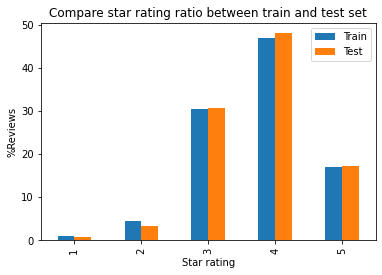

In [ ]:
_=df_target_ratio[['pct_train', 'pct_test']].plot(kind='bar', title="Compare star rating ratio between train and test set")
plt.legend(['Train','Test'])
plt.xlabel("Star rating")
plt.ylabel("%Reviews")

**Finding:**
- The star_rating should be adjusted since the actual score on Wongnai application is from 1-5 stars
- The ratio on both train and test set is quite similar. Around half is on 4 stars (after adjustment) followed by 3 stars (after adjustment)
- Train and test set seem perfectly satisfied the samples. 

## Word cloud

In [ ]:
# ref: https://www.google.com/search?q=thai+word+cloud&rlz=1C1CHBF_enTH769TH770&oq=thai+word+cloud&aqs=chrome..69i57j0i22i30j0i390l4j69i64l2.2553j0j4&sourceid=chrome&ie=UTF-8

from PIL import Image
from wordcloud import WordCloud

In [ ]:
!wget https://www.f0nt.com/download/sipafonts/THSarabunNew.zip; unzip THSarabunNew.zip

--2022-06-20 14:37:37--  https://www.f0nt.com/download/sipafonts/THSarabunNew.zip
Resolving www.f0nt.com (www.f0nt.com)... 103.246.18.21, 2401:5700:100:503::1821
Connecting to www.f0nt.com (www.f0nt.com)|103.246.18.21|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.f0nt.com/files/sipafonts/THSarabunNew.zip [following]
--2022-06-20 14:37:37--  https://www.f0nt.com/files/sipafonts/THSarabunNew.zip
Reusing existing connection to www.f0nt.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 434047 (424K) [application/zip]
Saving to: ‚ÄòTHSarabunNew.zip.1‚Äô

THSarabunNew.zip.1  100%[===================>] 423.87K  1.27MB/s    in 0.3s    

2022-06-20 14:37:38 (1.27 MB/s) - ‚ÄòTHSarabunNew.zip.1‚Äô saved [434047/434047]

Archive:  THSarabunNew.zip
replace THSarabunNew Italic.ttf? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: THSarabunNew Italic.ttf  
  inflating: __MACOSX/._THSarabunNew Italic.ttf  
  inflating: THSarabunNew.ttf    

In [ ]:
def plot_wordclound(text):
  regexp = r"[‡∏Å-‡πôa-zA-Z']+"
  wordcloud = WordCloud(
                        font_path="/content/THSarabunNew.ttf", 
                        relative_scaling = 0.3,
                        min_font_size=1,
                        background_color="white",
                        width=1024,
                        height=768,
                        max_words=2000, 
                        stopwords = thai_stopwords(),
                        # mask=mask,
                        colormap='plasma', 
                        scale=3,
                        font_step=4,
                      #   contour_width=3, 
                      #   contour_color='steelblue', 
                        collocations=False,
                        regexp=regexp,
                        margin=2
                        ).generate(text)

  fig, ax = plt.subplots(1, 1, figsize=(16, 12))
  ax.imshow(wordcloud, interpolation='bilinear')
  ax.axis("off")
  fig.show()

Text(0.5, 1.0, 'wordcloud for all reviews in training dataset')

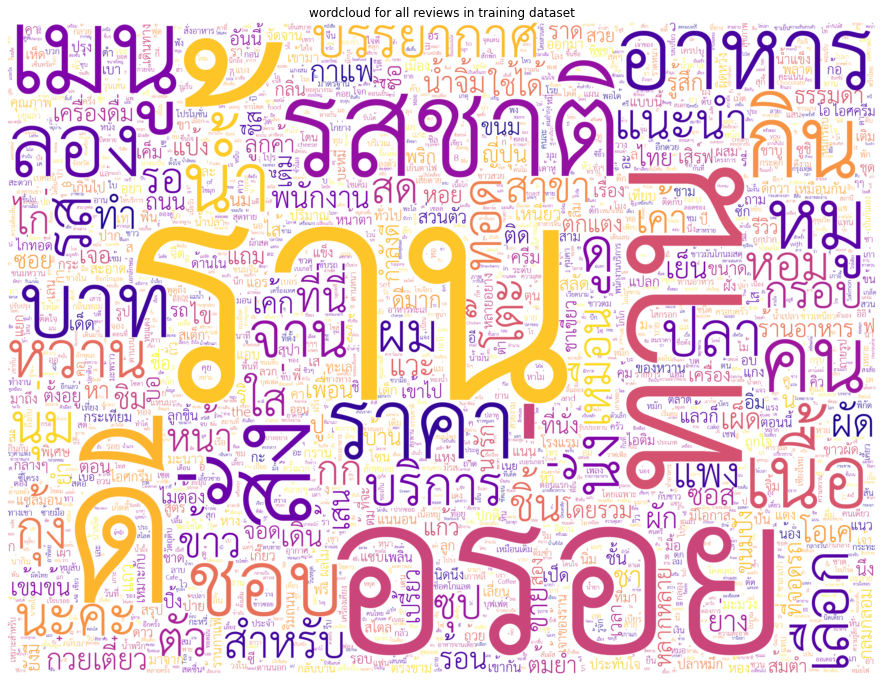

In [ ]:
# text = df_train.review_body[4]
text = " ".join(df_train.processed_review_body.apply(lambda x: " ".join(x)))
plot_wordclound(text)
plt.title("wordcloud for all reviews in training dataset")

Text(0.5, 1.0, 'wordcloud for reviews with star rating = 1 in training dataset')

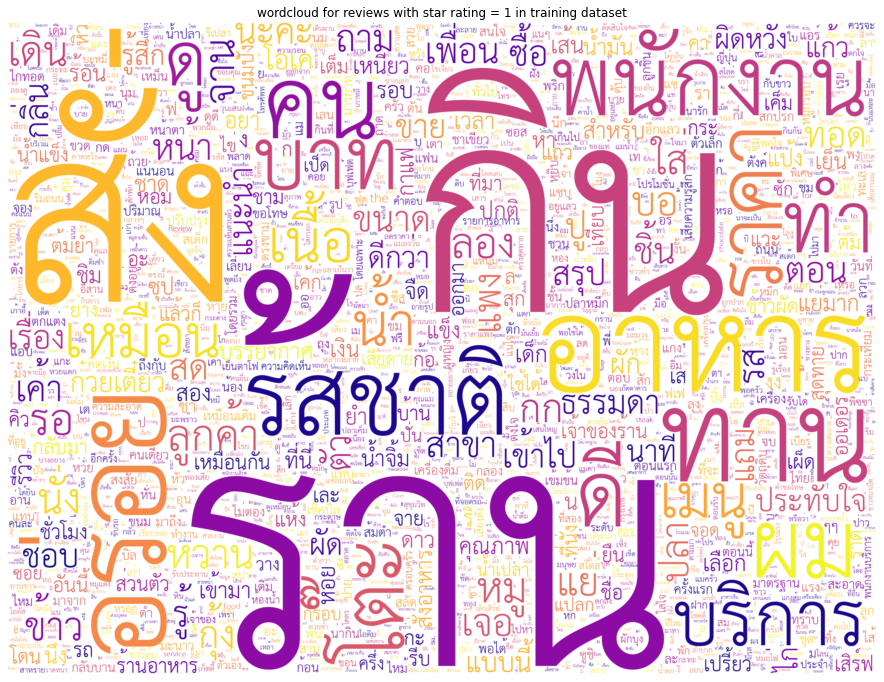

In [ ]:
# star_rating == 1
text = " ".join(df_train.loc[df_train.star_rating==1,"processed_review_body"].apply(lambda x: " ".join(x)))
plot_wordclound(text)

plt.title("wordcloud for reviews with star rating = 1 in training dataset")

Text(0.5, 1.0, 'wordcloud for reviews with star rating = 5 in training dataset')

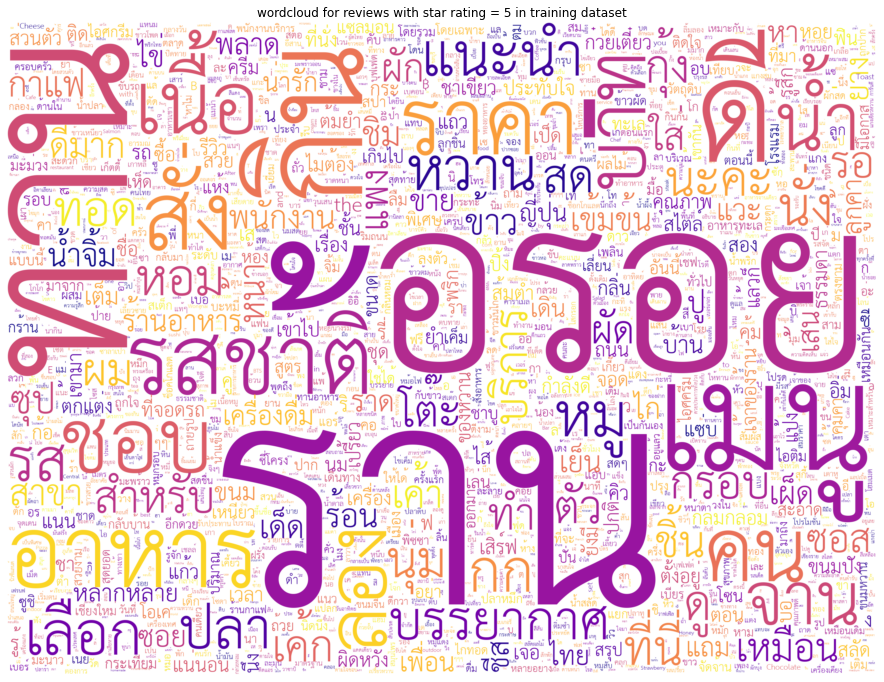

In [ ]:
# star_rating == 5
text = " ".join(df_train.loc[df_train.star_rating==5,"processed_review_body"].apply(lambda x: " ".join(x)))
plot_wordclound(text)

plt.title("wordcloud for reviews with star rating = 5 in training dataset")

# üñ§ Bag of Word

In [ ]:
# Create X, y
X = df_train.review_body
y = df_train.star_rating

# define X_test, y_test
X_test = df_test.review_body
y_test = df_test.star_rating

# Split X,y for train and valid

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

# # Create TFIDF Vectorizer and transform predefined X
tfidf = TfidfVectorizer(tokenizer=process_text, ngram_range=(1,2), min_df=20, sublinear_tf=True)
tfidf_fit = tfidf.fit(X_train)
X_train_tfidf = tfidf_fit.transform(X_train)
X_val_tfidf = tfidf_fit.transform(X_val)
X_test_tfidf = tfidf_fit.transform(X_test)

In [ ]:
# See example of TFIDF
i = 10

print(f"original: {X_train[i]}")
print(f"TFIDF: {X_train_tfidf[i]}")
# print(f"Array format: {[np.where(tfidf.get_feature_names_out() == x) for x in train_df['processed'].values.tolist()[0].split('|')[:5]]}")

original: ‡∏û‡∏≤‡∏°‡∏≤‡∏•‡∏≠‡∏á‡∏≠‡∏∞‡πÑ‡∏£‡πÉ‡∏Å‡∏•‡πâ‡πÜ ‡∏ö‡πâ‡∏≤‡∏ô‡∏ö‡πâ‡∏≤‡∏á‡∏Ñ‡∏£‡∏±‡∏ö .. ‡∏£‡πâ‡∏≤‡∏ô "‡∏ß‡∏±‡∏ß‡∏´‡∏±‡∏ß‡πÄ‡∏£‡∏≤‡∏∞" ‡πÄ‡∏õ‡πá‡∏ô‡∏£‡πâ‡∏≤‡∏ô‡∏≠‡∏≤‡∏´‡∏≤‡∏£‡∏™‡πÑ‡∏ï‡∏•‡πå ‡∏à‡∏¥‡πâ‡∏°‡∏à‡∏∏‡πà‡∏° ‡∏õ‡∏¥‡πâ‡∏á‡∏¢‡πà‡∏≤‡∏á ‡∏ü‡∏±‡∏á‡∏à‡∏≤‡∏Å‡∏ä‡∏∑‡πà‡∏≠‡∏£‡πâ‡∏≤‡∏ô‡πÅ‡∏•‡πâ‡∏ß‡∏ô‡πà‡∏≤‡∏à‡∏∞‡∏û‡∏≠‡πÄ‡∏î‡∏≤‡πÑ‡∏î‡πâ‡∏ß‡πà‡∏≤‡∏£‡πâ‡∏≤‡∏ô‡∏ô‡∏µ‡πâ "‡πÄ‡∏ô‡∏∑‡πâ‡∏≠" ‡∏ï‡πâ‡∏≠‡∏á‡πÄ‡∏î‡πá‡∏î‡πÅ‡∏ô‡πà‡∏ô‡∏≠‡∏ô

‡∏£‡πâ‡∏≤‡∏ô‡∏ô‡∏µ‡πâ‡∏≠‡∏¢‡∏π‡πà‡∏ö‡∏£‡∏¥‡πÄ‡∏ß‡∏ì‡πÅ‡∏¢‡∏Å‡∏ö‡∏≤‡∏á‡∏û‡∏•‡∏±‡∏î‡∏Ñ‡∏£‡∏±‡∏ö ‡∏ñ‡πâ‡∏≤‡∏°‡∏≤‡∏à‡∏≤‡∏Å‡∏ñ‡∏ô‡∏ô‡∏à‡∏£‡∏±‡∏ç‡∏™‡∏ô‡∏¥‡∏ó‡∏ß‡∏á‡∏®‡πå (‡πÑ‡∏°‡πà‡∏ß‡πà‡∏≤‡∏à‡∏∞‡∏ó‡∏≤‡∏á‡πÑ‡∏´‡∏ô‡∏Å‡πá‡∏ï‡∏≤‡∏°) ‡πÉ‡∏´‡πâ‡πÄ‡∏•‡∏µ‡πâ‡∏¢‡∏ß‡πÄ‡∏Ç‡πâ‡∏≤‡∏ñ‡∏ô‡∏ô‡∏™‡∏¥‡∏£‡∏¥‡∏ò‡∏£ (‡∏ó‡∏µ‡πà‡∏à‡∏∞‡∏°‡∏∏‡πà‡∏á‡∏´‡∏ô‡πâ‡∏≤‡πÑ‡∏õ‡∏¢‡∏±‡∏á‡∏ï‡∏±‡πâ‡∏á‡∏Æ‡∏±‡πà‡∏ß‡πÄ‡∏™‡πá‡∏á‡∏ò‡∏ô‡∏ö‡∏∏‡∏£‡∏µ) ‡∏ï‡∏£‡∏á‡πÑ‡∏õ‡πÑ‡∏°‡πà‡∏Å‡∏µ‡πà‡∏£‡πâ‡∏≠‡∏¢‡πÄ‡∏°‡∏ï‡∏£ ‡∏ö‡∏£‡∏¥‡πÄ‡∏ß‡∏ì‡πÄ‡∏ä‡∏¥‡∏á‡∏™‡∏∞‡∏û‡∏≤‡∏ô‡∏Ç‡πâ‡∏≤‡∏°‡πÅ‡∏¢‡∏Å‡∏ö‡∏≤‡∏á‡∏û‡∏•‡∏±‡∏î ‡∏à‡∏∞‡πÄ‡∏´‡πá‡

In [ ]:
# see TFIDF feature name
tfidf.get_feature_names_out()

array(['', ' ', ' (', ..., '‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è ‡∏£‡∏™‡∏ä‡∏≤‡∏ï‡∏¥', '‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è', '‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è‚≠êÔ∏è'],
      dtype=object)

In [ ]:
# model training

model = LogisticRegression(C=2., penalty='l2', solver='liblinear', dual=False, multi_class='ovr')
model.fit(X_train_tfidf,y_train)
model.score(X_val_tfidf,y_val)

0.5429545454545455

In [ ]:
from sklearn.metrics import classification_report
y_val_pred = model.predict(X_val_tfidf)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           1       0.67      0.03      0.06       139
           2       0.47      0.07      0.12       622
           3       0.53      0.49      0.51      3990
           4       0.56      0.76      0.64      6198
           5       0.47      0.20      0.28      2251

    accuracy                           0.54     13200
   macro avg       0.54      0.31      0.32     13200
weighted avg       0.53      0.54      0.51     13200



In [ ]:
# sample test case

sample = ['‡∏£‡πâ‡∏≤‡∏ô‡∏≠‡∏≤‡∏´‡∏≤‡∏£‡∏£‡πâ‡∏≤‡∏ô‡∏ô‡∏µ‡πâ‡∏≠‡∏£‡πà‡∏≠‡∏¢‡∏î‡∏µ','‡∏≠‡∏≤‡∏´‡∏≤‡∏£‡∏£‡πâ‡∏≤‡∏ô‡∏ô‡∏µ‡πâ‡πÑ‡∏°‡πà‡∏≠‡∏£‡πà‡∏≠‡∏¢‡πÄ‡∏•‡∏¢']
sample_feature = tfidf_fit.transform(sample)
model.predict(sample_feature)

array([4, 5])

# üñ§ RNN/LSTM

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# Define y
y = df_train.star_rating
y_test =df_test.star_rating

# Define X
X = df_train.processed_review_body.apply(lambda x: " ".join(x)).values.tolist()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
X_test = df_test.processed_review_body.apply(lambda x: " ".join(x)).values.tolist()

In [ ]:
print(len(X))
print(len(X_train))

20001
13400


In [ ]:
word_count = []
for sent in X_train:
  for w in sent.split():
      word_count.append(w)

In [ ]:
VOCAB_SIZE = len(set(word_count))
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(X_train)

In [ ]:
y_class = [1, 2, 3, 4, 5]

In [ ]:
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical

le = preprocessing.LabelEncoder()
le.fit(y_class)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
print(y_train.shape)

(13400, 5)


In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=512,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

In [ ]:
sample_text = ('‡∏£‡πâ‡∏≤‡∏ô‡∏≠‡∏≤‡∏´‡∏≤‡∏£‡∏£‡πâ‡∏≤‡∏ô‡∏ô‡∏µ‡πâ‡∏≠‡∏£‡πà‡∏≠‡∏¢‡∏°‡∏≤‡∏Å')
predictions = model.predict(np.array([sample_text]))
print(predictions)
le.classes_

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[[0.19889289 0.20102702 0.19723158 0.2009634  0.20188504]]


array([1, 2, 3, 4, 5])

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
model.fit(np.array(X_train), y_train, validation_data=(np.array(X_val), y_val), epochs=3, verbose=1)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
418/419 [============================>.] - ETA: 0s - loss: 1.2413 - accuracy: 0.4610WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f92b56e9200> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the

In [ ]:
value = model.predict(np.array(X_val))
y_val_pred = np.argmax(value,axis=1)
y_val_true = np.argmax(y_val,axis=1)
print(classification_report(y_val_true, y_val_pred))

              precision    recall  f1-score   support

           0       0.22      0.03      0.05        67
           1       0.31      0.27      0.29       291
           2       0.51      0.43      0.47      2007
           3       0.55      0.73      0.63      3161
           4       0.42      0.19      0.26      1075

    accuracy                           0.52      6601
   macro avg       0.41      0.33      0.34      6601
weighted avg       0.51      0.52      0.50      6601



# üñ§ Pretrained Representation (CNN)

In [ ]:

enc = hub.load('https://tfhub.dev/google/universal-sentence-encoder-multilingual/3')

In [ ]:
# Define train/val
train, val = train_test_split(df_train, test_size=0.2)

# Define y
y_train = train.star_rating
y_test =df_test.star_rating
y_val = val.star_rating


# Define X
X_trains = []
X_vals = []
bs = 10

for i in tqdm_notebook(range(y_val.shape[0]//bs+1)):
    X_vals.append(enc(val.review_body[(i*bs):((i+1)*bs)]).numpy())

for i in tqdm_notebook(range(y_train.shape[0]//bs+1)):
    X_trains.append(enc(train.review_body[(i*bs):((i+1)*bs)]).numpy())


X_val = np.concatenate(X_vals,0)
X_train = np.concatenate(X_trains,0)
X_train.shape, X_val.shape

# train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/401 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1601 [00:00<?, ?it/s]

((16000, 512), (4001, 512))

In [ ]:
from sklearn.svm import LinearSVC

text_clf = LinearSVC(class_weight='balanced')
text_clf.fit(X_train, y_train)

LinearSVC(class_weight='balanced')

In [ ]:
y_val_pred = text_clf.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.11      0.45      0.17        44
           1       0.15      0.34      0.21       192
           2       0.47      0.40      0.43      1219
           3       0.56      0.49      0.52      1856
           4       0.34      0.36      0.35       690

    accuracy                           0.43      4001
   macro avg       0.33      0.41      0.34      4001
weighted avg       0.47      0.43      0.44      4001



# üñ§ Learning Model: BERT

In [ ]:
!pip -q install thai2transformers==0.1.1
!pip install torch==1.7.0

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1.3 MB 7.5 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1.1 MB 43.3 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8.7 MB 8.2 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 43 kB 1.9 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 585 kB 63.4 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 473 kB 72.5 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2.9 MB 55.3 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 87 kB 8.1 MB/s 
     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà

In [ ]:
import pandas as pd
from datasets import load_dataset, load_metric

import torch
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          TrainingArguments,
                          Trainer)
from thai2transformers.tokenizers import (
    ThaiRobertaTokenizer,
    ThaiWordsNewmmTokenizer,
    ThaiWordsSyllableTokenizer,
    FakeSefrCutTokenizer
)
from thai2transformers.metrics import classification_metrics

In [ ]:
#parameters
class Args:
    model_name = 'airesearch/wangchanberta-base-att-spm-uncased'
    dataset_name_or_path = 'wongnai_reviews'
    feature_col = 'review_body'
    label_col = 'star_rating'
    output_dir = 'models_wongnai/wangchanberta-base-att-spm-uncased_wongnai'
    batch_size = 16
    warmup_percent = 0.1
    learning_rate = 3e-05
    num_train_epochs = 1
    weight_decay = 0.01
    metric_for_best_model = 'f1_micro'
    seed = 1412

args = Args()

In [ ]:
dataset = load_dataset(args.dataset_name_or_path)
dataset = dataset.map(lambda examples: {'labels': examples[args.label_col]}, batched=True)
num_labels = len(set(dataset['train']['labels']))
dataset

Using custom data configuration default
Reusing dataset wongnai_reviews (/root/.cache/huggingface/datasets/wongnai_reviews/default/1.0.1/0741f812b51dea635d957a5cc8f46fcc98828c0f6c557336ab20367778299a4d)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['review_body', 'star_rating', 'labels'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review_body', 'star_rating', 'labels'],
        num_rows: 6203
    })
})

In [ ]:
#create tokenizer
tokenizer = AutoTokenizer.from_pretrained(args.model_name, model_max_length=416)

#encode dataset
def encode_function(examples):
    return tokenizer(examples[args.feature_col], truncation=True)
encoded_dataset = dataset.map(encode_function, batched=True)

  0%|          | 0/40 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [ ]:
#create model
model = AutoModelForSequenceClassification.from_pretrained(args.model_name, num_labels=num_labels)

Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wa

In [ ]:
train_args = TrainingArguments(
    output_dir = args.output_dir,
    evaluation_strategy = "epoch",
    learning_rate=args.learning_rate,
    per_device_train_batch_size=args.batch_size,
    per_device_eval_batch_size=args.batch_size,
    num_train_epochs=args.num_train_epochs,
    warmup_steps = int(len(encoded_dataset['train']) * args.num_train_epochs // args.batch_size * args.warmup_percent),
    weight_decay=args.weight_decay,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model=args.metric_for_best_model,
    seed = args.seed
)

In [ ]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=classification_metrics
)

In [ ]:
import pandas as pd

In [ ]:
preds  = trainer.predict(encoded_dataset['test'])
pd.DataFrame.from_dict(preds[2],orient='index').transpose()

eval_loss  eval_accuracy  eval_f1_micro  eval_precision_micro  \
0   1.570988       0.281799       0.281799              0.281799   

   eval_recall_micro  eval_f1_macro  eval_precision_macro  eval_recall_macro  \
0           0.281799       0.195464              0.213695           0.212555   

   eval_nb_samples  
0           6203.0

In [ ]:
trainer.train()

TrainOutput(global_step=2500, training_loss=0.99000791015625)

In [ ]:
preds  = trainer.predict(encoded_dataset['test'])
pd.DataFrame.from_dict(preds[2],orient='index').transpose()

eval_loss  eval_accuracy  eval_f1_micro  eval_precision_micro  \
0   0.872649       0.615509       0.615509              0.615509   

   eval_recall_micro  eval_f1_macro  eval_precision_macro  eval_recall_macro  \
0           0.615509       0.495119              0.561767           0.472082   

   eval_nb_samples  
0           6203.0

# ‚≠ê Summary